# pystrat Minimal Working Example

This Jupyter notebook is intended to provide a minimal working example (MWE) of core pystrat functionality. The pystrat package can be found here: https://github.com/yuempark/pystrat

The user is encouraged to read the docstrings for each function for further information.

Note that all data used in this notebook is modified or fabricated for instructional purposes, and does not accurately reflect real collected data.

In [1]:
# built in modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pyStrat
from pystrat import *

To plot figures inline with text/code, we use the Jupyter "magic" command below.

In [2]:
%matplotlib inline 

You can save any figure by adding the following line before the `plt.show()` command:
```python
plt.savefig('<name_of_figure>.pdf')
```
The format of the saved figure is specified with the extension of the file name (example above uses pdf).

By default, matplotlib exports figures with all labels and text annotations converted to vector paths. However, it is often preferable to preserve these as text objects so that font, font size, etc. can easily be manipulated when importing the figure into Illustrator, for example. To do this, add the one of the following lines (depending on your preferred format) to a new cell and execute it.
```python
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
```

## Plot a Stratigraphic Section

Import the data - note that it must follow the formatting of `data_template.csv`. The data .csv must contain at least two headers: one of these headers MUST be named 'THICKNESS'. Other columns may be named whatever the user desires.

pystrat functions used:

* `read_data`

In [2]:
data = read_data('templates/data_template.csv', header=4)
data.head()

,THICKNESS,LITHOLOGY,GRAIN_SIZE,COLOUR,FEATURES,ASH_SAMPLE,ASH_HEIGHT,PM_SITE,PM_SAMPLE,PM_HEIGHT,CARB_SAMPLE,CARB_REMARKS,CARB_HEIGHT,CARB_UNIT,CARB_d13C,CARB_d18O
0,14.8,si,sts,purple,NaN,1-53.1,911.7,17T001,A,934.60,1.5,NaN,1.5,0,0.766,-0.814
1,0.2,tuff,tuff,tuff,NaN,1-148.0,1006.6,17T001,B,934.72,5.6,NaN,5.6,0,1.737,0.893
2,1.5,si,sts,purple,NaN,1-148.9,1007.5,17T001,C,935.04,12.0,NaN,12.0,0,1.882,0.732
3,4.8,cover,cover,cover,NaN,2-138.3,138.3,17T001,D,935.03,21.4,NaN,21.4,4,1.398,-0.682
4,3.7,si,sts,purple,NaN,2-159.4,159.4,17T001,E,935.14,25.5,NaN,25.5,6,1.661,-0.516


Import the formatting - note that it must follow the formatting of `formatting_template.csv`:

* Columns 1-4 are used to set the colour of the boxes
    * columns 1-3 must be called `r`, `g`, and `b` (for red, green, and blue), and values in columns 1-3 must be between 0-255
    * the header of column 4 must match one of the headers used in the data .csv, and all values in the data must be a subset of the values in this column
* Columns 6-7 are used to set the width of the boxes
    * column 6 must be called `width`
    * the header of column 7 must match one of the headers used in the data .csv, and all values in the data must be a subset of the values in this column
    * column 5 should be left blank for readability.

pystrat functions used:

* `read_formatting`

In [3]:
formatting = read_formatting('templates/formatting_template.csv')

Integrity check - check that values in the data are a subset of values in the formatting:

pystrat functions used:

* `integrity_check`

In [4]:
integrity_check(data, formatting)

Colour and width check passed.


Plot:

pystrat functions used:

* `initiate_figure`
* `add_data_axis`

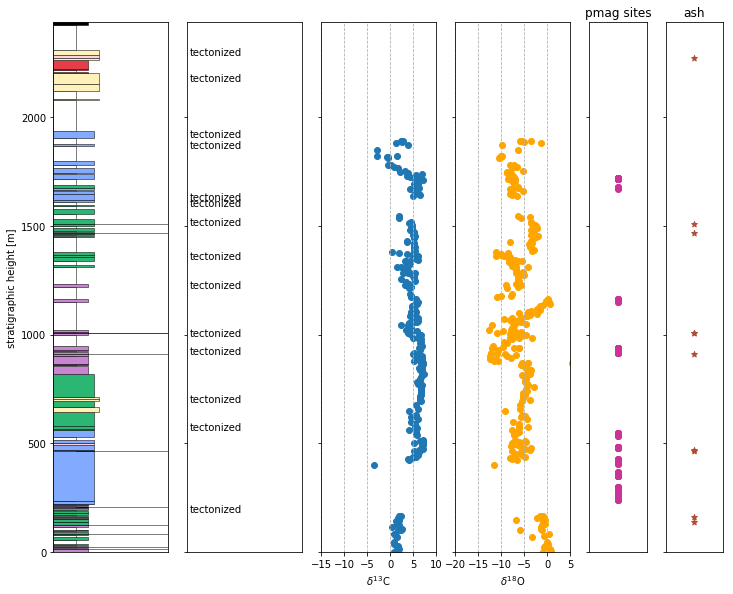

In [5]:
# set up the strat ratio which sets the vertical scale of the section
strat_ratio = 0.004

# initiate the figure and set size
fig, ax = initiate_figure(data, formatting, strat_ratio, figwidth=12,
                          width_ratios=[1,1,1,1,0.5,0.5], linewidth=0.5)

# add data for d13C
add_data_axis(fig, ax, 2, data['CARB_d13C'], data['CARB_HEIGHT'], 'scatter')
ax[2].set_xlabel('$\delta^{13}$C')
ax[2].set_xlim(-15,10)
ax[2].set_xticks([-15,-10,-5,0,5,10])
ax[2].xaxis.grid(ls='--')

# add data for d18O
add_data_axis(fig, ax, 3, data['CARB_d18O'], data['CARB_HEIGHT'], 'scatter',
              color='orange')
ax[3].set_xlabel('$\delta^{18}$O')
ax[3].set_xlim(-20,5)
ax[3].set_xticks([-20,-15,-10,-5,0,5])
ax[3].xaxis.grid(ls='--')

# add height of paleomag samples
add_data_axis(fig, ax, 4, np.zeros(len(data['PM_HEIGHT'])), data['PM_HEIGHT'],
              'scatter', color=[0.8, 0.2, 0.6])
ax[4].set_xticks([])
ax[4].set_title('pmag sites')

# add height of ash samples
add_data_axis(fig, ax, 5, np.zeros(len(data['ASH_HEIGHT'])), data['ASH_HEIGHT'],
              'scatter', color='#AF4A34',marker='*')
ax[5].set_xticks([])
ax[5].set_title('ash')

plt.show(fig)

## LOWESS Fitting

Locally weighted scatter plot smoothing. To perform the basic LOWESS:

pystrat functions used:

* `lowess_fit`

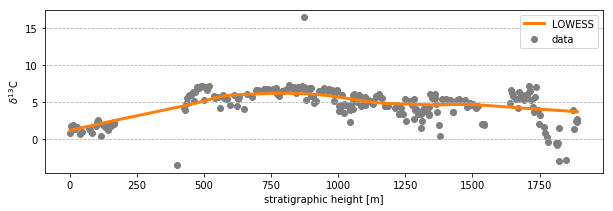

In [6]:
# the LOWESS fit
height_LOWESS, d13C_LOWESS = lowess_fit(data['CARB_HEIGHT'], data['CARB_d13C'], frac=0.5)

# plot the results
fig, ax = plt.subplots(figsize=(10,3))

ax.scatter(data['CARB_HEIGHT'], data['CARB_d13C'], c='C7', label='data')
ax.plot(height_LOWESS, d13C_LOWESS, c='C1', lw=3, label='LOWESS')
ax.yaxis.grid(ls='--')
ax.set_xlabel('stratigraphic height [m]')
ax.set_ylabel('$\delta^{13}$C')
ax.legend()

plt.show(fig)

To normalize the data against the LOWESS fit:

pystrat functions used:

* `lowess_normalize`

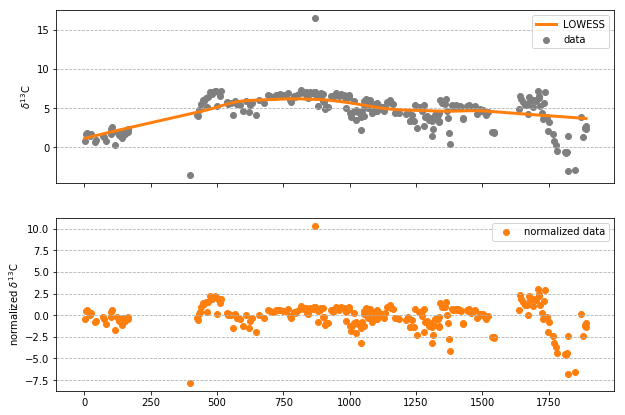

In [7]:
# the LOWESS fit
height_LOWESS, d13C_LOWESS, d13C_norm = lowess_normalize(data['CARB_HEIGHT'], data['CARB_d13C'], frac=0.5)

# plot the results
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,7))

ax[0].scatter(data['CARB_HEIGHT'], data['CARB_d13C'], c='C7', label='data')
ax[0].plot(height_LOWESS, d13C_LOWESS, c='C1', lw=3, label='LOWESS')
ax[0].yaxis.grid(ls='--')
ax[0].set_ylabel('$\delta^{13}$C')
ax[0].legend()

ax[1].scatter(data['CARB_HEIGHT'], d13C_norm, c='C1', label='normalized data')
ax[1].yaxis.grid(ls='--')
ax[1].set_ylabel('normalized $\delta^{13}$C')
ax[1].legend()

plt.show(fig)

## Calculate Stratigraphic Thickness

Given the following for the start and end points, calculate a stratigraphic thickness between two points:

* latitude (decimal degrees)
* longitude (decimal degrees)
* elevation (m)
* strike of bedding (RHR)
* dip of bedding

pystrat functions used:

* `calculate_stratigraphic_thickness`

In [8]:
# the data
lat = (28.00181863, 28.00386025)
lon = (108.7997006, 108.8009878)
elev = (1159, 1167)
strike = (342, 335)
dip = (41, 36)

d = calculate_stratigraphic_thickness(lat, lon, elev, strike, dip)

print('The stratigraphic distance between the two points is: ' + str(np.round(d,2)) + ' m')

The stratigraphic distance between the two points is: 130.5 m


If you have a .csv with a number of stratigraphic thicknesses that need to be calculated, there is a function for that too. Note that the .csv must follow the formatting of `covers_template.csv`:

pystrat functions used:

* `calculate_stratigraphic_thickness_csv`

In [9]:
covers = calculate_stratigraphic_thickness_csv('templates/covers_template.csv')
covers

,hash,start_lat,start_lon,start_elev,start_strike,start_dip,end_lat,end_lon,end_elev,end_strike,...,mean_pole_trend,mean_pole_plunge,mean_dip_direction,mean_dip,perp_s,d_elev,R,inclination,angle,HEIGHT
0,1,28.001819,108.799701,1159,342,41,28.003860,108.800988,1167,335,...,248.692351,51.551945,68.692351,38.448055,199.799057,8.0,199.959154,2.292911,49.259034,130.5
1,2,28.005680,108.801012,1188,258,36,28.006401,108.801845,1228,278,...,178.451551,52.423876,358.451551,37.576124,77.897445,40.0,87.567185,27.180302,25.243574,79.2
2,3,28.007272,108.800889,1197,235,38,28.007661,108.802249,1248,302,...,180.437912,54.525820,0.437912,35.474180,44.372894,51.0,67.601433,48.974880,5.550940,67.3
3,4,28.013522,108.804249,1239,304,23,28.013856,108.805201,1247,263,...,191.539857,65.913862,11.539857,24.086138,55.106565,8.0,55.684231,8.260110,57.653753,29.8
4,5,28.014832,108.805833,1243,220,34,28.015010,108.806121,1248,327,...,188.059110,66.176489,8.059110,23.823511,23.582054,5.0,24.106291,11.970892,54.205597,14.1
5,6,28.015208,108.806413,1248,327,39,28.015553,108.808079,1252,273,...,209.392732,53.215077,29.392732,36.784923,113.871126,4.0,113.941359,2.011826,51.203251,71.4
6,7,28.015316,108.808215,1259,273,41,28.015391,108.808820,1256,340,...,217.919857,52.122440,37.919857,37.877560,43.107607,-3.0,43.211871,-3.980983,48.141457,28.8
7,8,28.016244,108.809221,1261,306,31,28.019158,108.810916,1282,268,...,205.987792,69.823518,25.987792,20.176482,363.279150,21.0,363.885615,3.308403,66.515115,145.0
8,9,28.019514,108.811058,1276,268,11,28.020115,108.812450,1285,295,...,196.683902,72.398906,16.683902,17.601094,103.322926,9.0,103.714161,4.978215,67.420691,39.8
9,10,28.020663,108.812890,1293,295,25,28.021017,108.814922,1294,309,...,210.907800,68.642247,30.907800,21.357753,136.555154,1.0,136.558816,0.419572,68.222674,50.7


## Calculate Distance to Specified Units

Calculate the closest stratigraphic distance of each sample to a set of units:

pystrat functions used:

* `distance_to_units`

In [10]:
# let's say we are interested in seeing how close the samples are to either 'cover' or 'tuff' units
units = ['cover', 'tuff']

# the header of the column in 'data' in which to find the units in 'units'
unit_header = 'GRAIN_SIZE'

# run the function
unit_d = distance_to_units(data, data['CARB_HEIGHT'], units, unit_header)

We can plot the data, with samples within, say, 60cm of the specified units coloured differently:

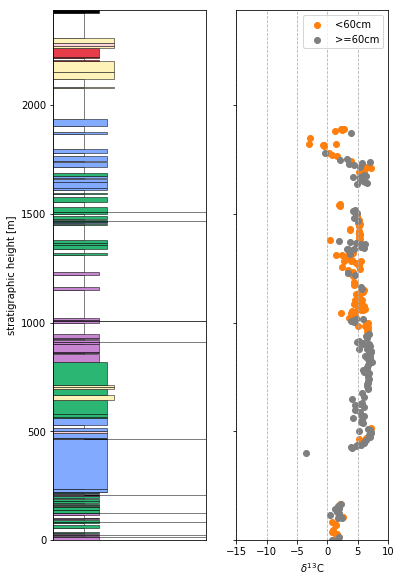

In [11]:
# initiate the figure
fig, ax = initiate_figure(data, formatting, strat_ratio, 6, [1,1], linewidth=0.5, features=False)

# add data for d13C that is below the threshold
add_data_axis(fig, ax, 1, data[unit_d<0.6]['CARB_d13C'], data[unit_d<0.6]['CARB_HEIGHT'], 'scatter',
              color='C1', label='<60cm')

# add data for d13C that is above the threshold
add_data_axis(fig, ax, 1, data[unit_d>=0.6]['CARB_d13C'], data[unit_d>=0.6]['CARB_HEIGHT'], 'scatter',
              color='C7', label='>=60cm')

# prettify
ax[1].set_xlabel('$\delta^{13}$C')
ax[1].set_xlim(-15,10)
ax[1].set_xticks([-15,-10,-5,0,5,10])
ax[1].xaxis.grid(ls='--')
ax[1].legend()

plt.show(fig)

## Assign Units to Samples

The functionality described here is useful if the user wishes to assign a stratigraphic unit (taken from the data .csv) to collected samples. This function also corrects for addition/subtraction errors made in the field, and assigns the correct stratigraphic height to collected samples.

Note that this function has been designed specifically around sample collection/logging conventions used in the Swanson-Hysell Group, and may not apply if your conventions differ:

* the `recorded_height` parameter is the height of each sample as recorded in the field
* the `remarks` parameter is used to denote calculation errors made in the field
    * if the true height of the sample is X m above the recorded height, write `ADD X`
    * if the true height of the sample is X m below the recorded height, write `SUB X`
    * these corrections only need to be noted at the first sample where the correction comes into effect (i.e. it will apply to all following samples until a new remark is found)
    
Below is an example of the recommended way to apply these functions:

pystrat functions used:

* `sample_curate`

In [12]:
# do the calculations
data_sample_info = sample_curate(data, data['CARB_SAMPLE'], data['CARB_REMARKS'])

The code will flag samples that are on unit boundaries by adding 0.5 to the unit number. User input is required to correctly identify which unit these samples belong to:

* if the sample comes from the lower unit, subtract 0.5
* if the sample comes from the upper unit, add 0.5

To make this manual process easier, the following snippet of code prints the code necessary to make adjustments to the unit number:

pystrat functions used:

* `print_unit_edit_code`

In [13]:
# print the code needed to edit samples that are on unit boundaries
print_unit_edit_code(data_sample_info, 'data_sample_info')

# also show the recorded height and true height of these samples
mask = (data_sample_info['unit'] != np.floor(data_sample_info['unit']))
data_sample_info[mask]

=====
data_sample_info.loc[101,'unit'] = 77.5
data_sample_info.loc[120,'unit'] = 80.5
data_sample_info.loc[257,'unit'] = 126.5
=====


,recorded_height,remarks,height,unit
101,928.1,NaN,928.1,77.5
120,1004.9,NaN,1004.9,80.5
257,1765.3,NaN,1765.3,126.5


Copy and paste the code that was printed by `print_unit_edit_code` into a new cell (as below), and edit the unit numbers as appropriate:

In [14]:
data_sample_info.loc[101,'unit'] = 77
data_sample_info.loc[120,'unit'] = 81
data_sample_info.loc[257,'unit'] = 126

To save the correct height and sample unit to the original data .csv, you can simply copy and paste the output table to the original data .csv:

In [15]:
pd.set_option("display.max_rows",9999)
data_sample_info

,recorded_height,remarks,height,unit
0,1.5,NaN,1.5,0.0
1,5.6,NaN,5.6,0.0
2,12.0,NaN,12.0,0.0
3,21.4,NaN,21.4,4.0
4,25.5,NaN,25.5,6.0
5,38.6,NaN,38.6,9.0
6,44.3,ADD 1.0,45.3,9.0
7,70.1,NaN,71.1,11.0
8,74.3,NaN,75.3,11.0
9,80.6,NaN,81.6,14.0
